***Introduction: Tomato Disease Classification Model***

NOTE: My initial project was in my present field software engineering and security, the problem was a classification problem with was based on identifying vulnerabilities in merge request. But to due to request to use anonymalized data was not approved by my employer hence the change in topic.

In [2]:
import os
import pathlib
import hashlib
import webbrowser
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
# from keras.models import Model
from keras.optimizers import Adam
import tensorflow_datasets as tfds
from keras.models import load_model
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Dropout


/Users/ademolabadmus/.pyenv/versions/3.9.18/envs/.imp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Data Source and Model Research**

In [ ]:

"""
    Don't run this file. It is just a script to open the URLs in the browser.
    But go ahead and copy the URLs and paste them in your browser.
"""
# URLs for online databases and research journals that might have datasets on tomato diseases
urls = [
    "https://www.google.com/",
    "https://www.kaggle.com/",
    "https://archive.ics.uci.edu/ml/index.php",
    "https://www.sciencedirect.com/",
    "https://www.springer.com/gp",
    "https://www.mdpi.com/",
    "https://onlinelibrary.wiley.com/",
    "https://www.nature.com/"
]

# Opening the URLs in separate tabs
for url in urls:
    webbrowser.open_new_tab(url)


**Data Cleaning: Removing duplicates from curated data**

In [3]:

def remove_duplicates(directory):
    """
    Remove duplicate images from a directory. It assumes images with different
    filenames are labeled differently.

    Args:
        directory (str): The path to the directory containing the images.

    Returns:
        None
    """

    # Dictionary to store image hashes
    hashes = {}

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            filepath = os.path.join(directory, filename)

            # Open the image and convert it to a consistent format
            with Image.open(filepath) as img:
                # Convert image to bytes
                img_bytes = img.tobytes()
                # Calculate hash of the image bytes
                img_hash = hashlib.md5(img_bytes).hexdigest()

                if img_hash in hashes:
                    # If the hash is already in the dictionary, delete the file
                    os.remove(filepath)
                    print(f"Removed duplicate image: {filename}")
                else:
                    # Otherwise, add the hash to the dictionary
                    hashes[img_hash] = filename
                    print(f"Image {filename} is unique.")

# Usage
remove_duplicates('diseases-tomato/Anthracnose')
remove_duplicates('diseases-tomato/Bacterial Speck Spot')
remove_duplicates('diseases-tomato/Bacterial Wilt')
remove_duplicates('diseases-tomato/Blight')
remove_duplicates('diseases-tomato/Beet Curly Top Virus (BCTV)')
remove_duplicates('diseases-tomato/Blossom End Rot')
remove_duplicates('diseases-tomato/Root Knot')
remove_duplicates('diseases-tomato/Septoria Leaf Spot')
remove_duplicates('diseases-tomato/Southern Blight')

Image Anthracnose Fruit Rot-30.jpeg is unique.
Image Anthracnose Fruit Rot-26.jpeg is unique.
Image Anthracnose Fruit Rot-8.png is unique.
Image Anthracnose Fruit Rot-7.jpeg is unique.
Image Anthracnose Fruit Rot-11.jpeg is unique.
Image Anthracnose Fruit Rot-6.jpeg is unique.
Image Anthracnose Fruit Rot-leaf-5.jpeg is unique.
Image Anthracnose Fruit Rot-29.png is unique.
Image Anthracnose Fruit Rot-27.jpeg is unique.
Image Anthracnose Fruit Rot-31.jpeg is unique.
Image Anthracnose Fruit Rot-16.jpeg is unique.
Image Anthracnose Fruit Rot-20.jpeg is unique.
Image Anthracnose Fruit Rot-21.jpeg is unique.
Image Anthracnose Fruit Rot-17.jpeg is unique.
Image Anthracnose Fruit Rot-14.jpeg is unique.
Image Anthracnose Fruit Rot-3.jpeg is unique.
Image Anthracnose Fruit Rot-18.jpeg is unique.
Image Anthracnose Fruit Rot-22.jpeg is unique.
Image Anthracnose Fruit Rot-19.jpeg is unique.
Image Anthracnose Fruit Rot-2.jpeg is unique.
Image Anthracnose Fruit Rot-15.jpeg is unique.
Image Anthracnos

**Data: fitting the data set**

In [17]:
"""
This script sets up the configuration parameters for training a tomato disease classification model using TensorFlow.
"""

print("Tensorflow Version: ",tf.__version__)

batch_size = 64
img_height = 224
img_width = 224
dataset_url = "diseases-tomato"
epochs = 50
initial_learning_rate = 0.0001
save_dir = 'model/h5/imperial/tomato_disease_model.h5'

Tensorflow Version:  2.15.0


Found 152 files belonging to 10 classes.
Using 107 files for training.


Found 152 files belonging to 10 classes.
Using 45 files for validation.
['Anthracnose', 'Bacterial Speck Spot', 'Bacterial Wilt', 'Beet Curly Top Virus (BCTV)', 'Blight', 'Blossom End Rot', 'Healthy', 'Root Knot', 'Septoria Leaf Spot', 'Southern Blight']
(64, 224, 224, 3)
(64,)


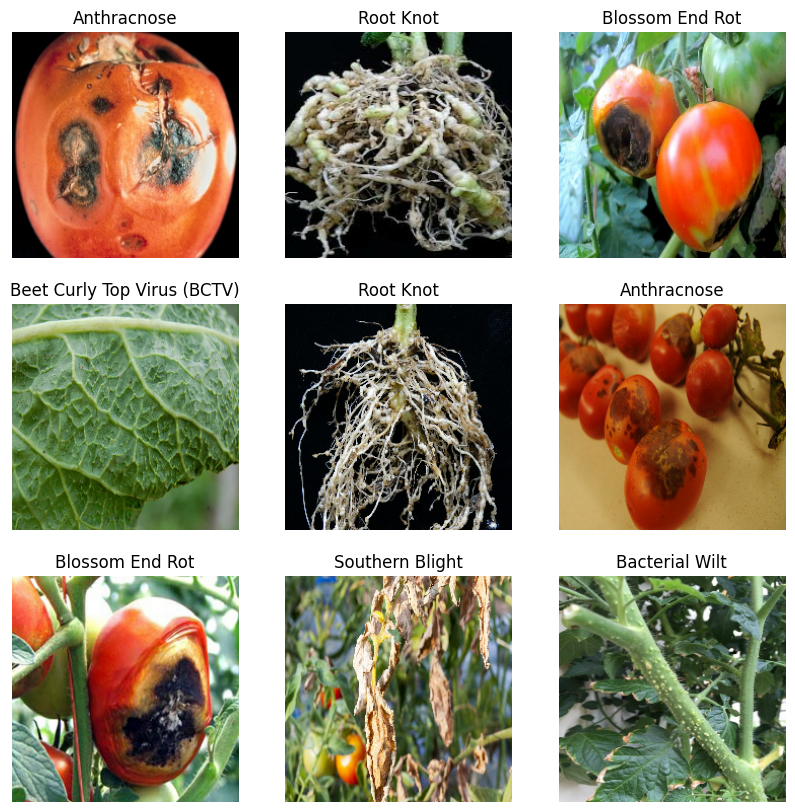

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url, 
  validation_split=0.3,
  seed=1337,
  subset="training", 
  image_size=(img_height, img_width), 
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split=0.3,
  subset="validation",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Print all the classes of images
class_names = train_ds.class_names
print(class_names)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [19]:
# Yield data from the disk without having I/O blocking
# Cache data in memory before training
# Prefetch data to optimize GPU utilization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

# Data Augmentation to prevent overfitting
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

0.0 1.0


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 112)     3136      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 112, 112, 112)     0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 56)      56504     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 56, 56, 56)        0         
 ng2D)                                                

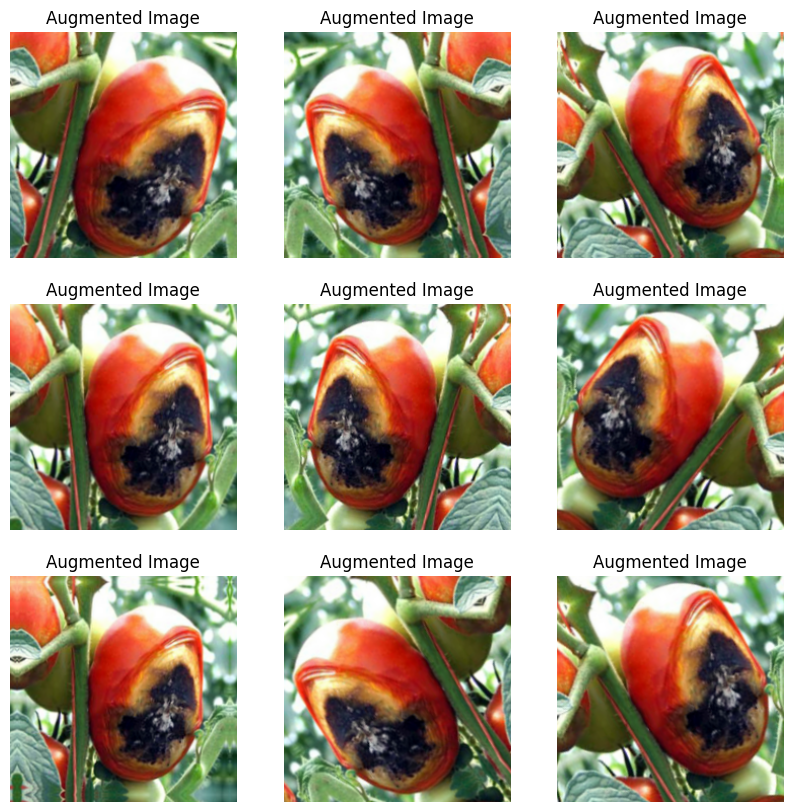

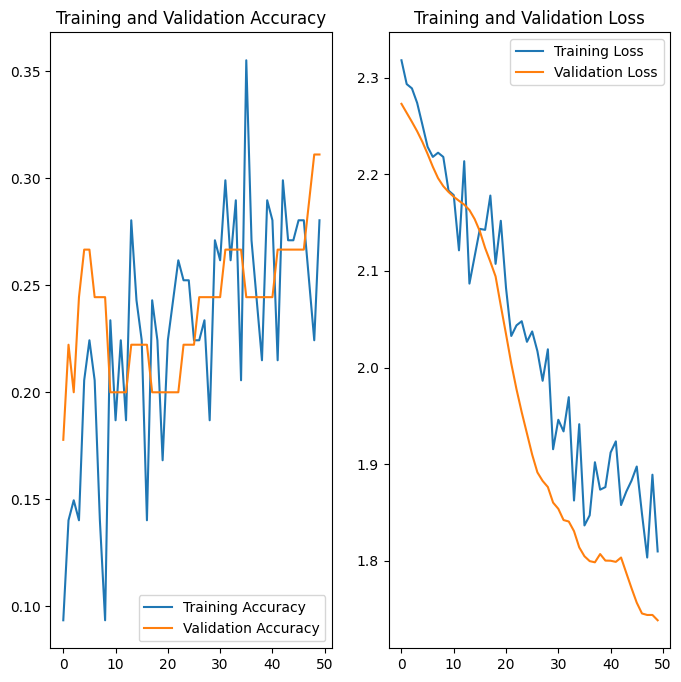

In [21]:
# Initializing the CNN
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(112, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size = (2, 2)),
  layers.Conv2D(56, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size = (2, 2)),
  layers.Conv2D(28, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size = (2, 2)),
  layers.Conv2D(14, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size = (2, 2)),
  # layers.Conv2D(7, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(pool_size = (2, 2)),
  layers.Flatten(),
  # Hidden layer
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  # Output layer
  layers.Dense(num_classes, activation = 'softmax')
])

# Define the initial learning rate and create a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
# `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs; Adam(learning_rate=lr_schedule)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=10,
    restore_best_weights=True
)

model.summary()

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  # callbacks=[early_stopping]
)

model.save(save_dir)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title("Augmented Image")
    plt.axis("off")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
np.set_printoptions(suppress=True)
model = load_model("model/h5/imperial/tomato_disease_model.h5", compile=False)
class_names = open("model/h5/imperial/labels.txt", "r").readlines()
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
image = Image.open("test-disease-tomato/tomato-test.jpg").convert("RGB")
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)
image_array = np.asarray(image)
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1
data[0] = normalized_image_array
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[1:], end="")
print("Confidence Score: ", confidence_score)


1/1 [==============================] - 0s 136ms/step
Class:  Anthracnose Rot
Confidence Score:  0.13385773
